# Extracting key information from documents

In previous notebook, I applied topic model. But,I only used random topic number. There is actually a way to find optimal number of topics.

Also Bag of words and TFIDF models are implemented.

# 1)- Importing key modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import numpy as np 
import pickle
import pandas as pd 

#For Visuals
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import seaborn as sns
sns.set(rc={'figure.figsize':(12,7)})
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [4]:
# NLTK Stop words
import nltk  # for text manipulation 
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

import re    # for regular expressions 
import spacy # another text processing library like nltk
import en_core_web_md
nlp = en_core_web_md.load()

I personally like Spacy more than nltk. But, I never take sides so, I ll use both where they come handy

In [5]:
%reload_ext version_information
%version_information pandas,numpy, nltk, seaborn, matplotlib, re, PyPDF2,gensim, spacy, bokeh

Software,Version
Python,3.7.4 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython,7.8.0
OS,Darwin 19.0.0 x86_64 i386 64bit
pandas,0.25.1
numpy,1.17.2
nltk,3.4.5
seaborn,0.9.0
matplotlib,3.1.1
re,2.2.1
PyPDF2,1.26.0


# 2)- Loading Dataset

from kaggle : https://www.kaggle.com/benhamner/nips-papers/data

In [6]:
data=pd.read_csv('papers.csv')
data.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [7]:
data.columns

Index(['id', 'year', 'title', 'event_type', 'pdf_name', 'abstract',
       'paper_text'],
      dtype='object')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7241 entries, 0 to 7240
Data columns (total 7 columns):
id            7241 non-null int64
year          7241 non-null int64
title         7241 non-null object
event_type    2422 non-null object
pdf_name      7241 non-null object
abstract      7241 non-null object
paper_text    7241 non-null object
dtypes: int64(2), object(5)
memory usage: 396.1+ KB


In [9]:
data.shape

(7241, 7)

In [10]:
# we shall create a smaller dataset with our features of interest

dataset= data[['id','year','title','abstract','paper_text']]

In [11]:
dataset.shape

(7241, 5)

In [12]:
dataset.head()

,id,year,title,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [13]:
dataset.tail()

,id,year,title,abstract,paper_text
7236,994,1994,Single Transistor Learning Synapses,Abstract Missing,Single Transistor Learning Synapses\n\nPaul Ha...
7237,996,1994,"Bias, Variance and the Combination of Least Sq...",Abstract Missing,"Bias, Variance and the Combination of\nLeast S..."
7238,997,1994,A Real Time Clustering CMOS Neural Engine,Abstract Missing,A Real Time Clustering CMOS\nNeural Engine\nT....
7239,998,1994,Learning direction in global motion: two class...,Abstract Missing,Learning direction in global motion: two\nclas...
7240,999,1994,Correlation and Interpolation Networks for Rea...,Abstract Missing,Correlation and Interpolation Networks for\nRe...


In previous excercise, we have done data exploring so, I will not repeat whole process.

# 3)- Text Cleaning

In [14]:
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

In [15]:
corpus = []
for i in range(0, 7241): # size of total documents within our dataset
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', dataset['paper_text'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [16]:
dataset['clean']=corpus

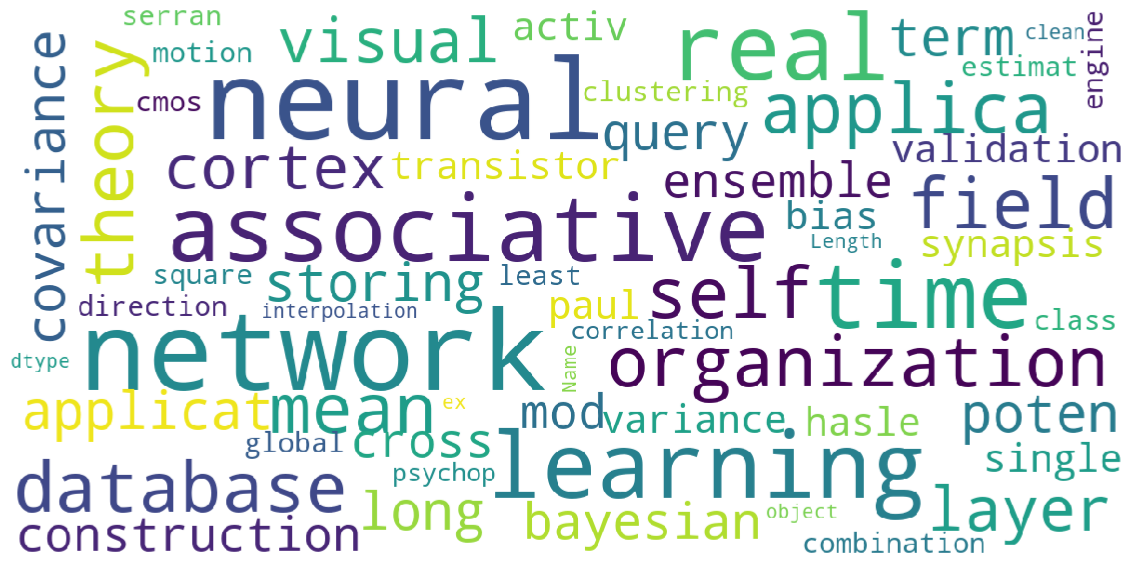

In [17]:
from wordcloud import WordCloud, STOPWORDS
stopwords=set(STOPWORDS)

def Mywordcloud (data, title=None):
    wordcloud=WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words= 100 ,
    max_font_size=40 ,
    scale=3,
    random_state=1
    ).generate(str(data))
    
    fig=plt.figure(1 , figsize(20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    
    plt.imshow(wordcloud)
    plt.show()
Mywordcloud(dataset['clean'].dropna())

# 4)-Pre-Model 

We shall use two techniques

- Bag of words
- TFIDF

### 4.1)- Bag of words

#### 4.1.a)- Create Dictionary

id2word will be a dictionary that contains words i.e All of our data word.

In [18]:
token=dataset['clean'].apply(lambda x: x.split())

In [19]:
token[:5]

0    [self, organization, associative, database, ap...
1    [mean, field, theory, layer, visual, cortex, a...
2    [storing, covariance, associative, long, term,...
3    [bayesian, query, construction, neural, networ...
4    [neural, network, ensemble, cross, validation,...
Name: clean, dtype: object

In [20]:
data_ready=token

In [21]:
from gensim import corpora, models
id2word = corpora.Dictionary(data_ready)

In [22]:
print(len(id2word))

167705


In [23]:
type(id2word)

gensim.corpora.dictionary.Dictionary

In [24]:
count = 0
for k, v in id2word.iteritems():
    print(k, v, id2word.dfs[k])
    count += 1
    if count > 10:
        break

0 abolish 8
1 abstract 7179
2 accelerate 244
3 acceptable 274
4 accomplishes 61
5 accordingly 622
6 achieve 2991
7 achieved 2720
8 actual 1747
9 adap 8
10 add 1930


**Filter out tokens that appear in**

- less than 15 documents (absolute number) or
- more than 0.5 documents (fraction of total corpus size, not absolute number).
- after the above two steps, keep only the first 4000 most frequent tokens.

In [25]:
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=4000)

In [26]:
print(len(id2word))

4000


In [27]:
print(id2word[3])

achieve


#### 4.1.b)-Create corpus: Term Document Freq

In [28]:
corpus = [id2word.doc2bow(text) for text in data_ready]

In [29]:
print(len(corpus))

7241


In [30]:
bow_doc_500 = corpus[500]

for i in range(len(bow_doc_500)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_500[i][0], 
                                                     id2word[bow_doc_500[i][0]], 
                                                     bow_doc_500[i][1]))

Word 3 ("achieve") appears 1 time.
Word 4 ("achieved") appears 2 time.
Word 12 ("american") appears 1 time.
Word 14 ("angle") appears 1 time.
Word 22 ("architecture") appears 2 time.
Word 25 ("around") appears 1 time.
Word 32 ("assumed") appears 1 time.
Word 48 ("bottom") appears 1 time.
Word 73 ("come") appears 1 time.
Word 116 ("develop") appears 1 time.
Word 119 ("difficult") appears 1 time.
Word 121 ("direction") appears 2 time.
Word 130 ("done") appears 2 time.
Word 145 ("environment") appears 9 time.
Word 154 ("estimation") appears 1 time.
Word 164 ("expression") appears 1 time.
Word 169 ("fast") appears 1 time.
Word 173 ("filter") appears 3 time.
Word 182 ("frequency") appears 4 time.
Word 192 ("half") appears 2 time.
Word 209 ("ii") appears 9 time.
Word 211 ("image") appears 7 time.
Word 214 ("implies") appears 1 time.
Word 227 ("institute") appears 2 time.
Word 228 ("int") appears 1 time.
Word 231 ("interaction") appears 2 time.
Word 245 ("learns") appears 1 time.
Word 258 ("m

Full list of words and their frequency.

### 4.2)- TFIDF

We already have drawn id2word. So we shall go with corpus

In [31]:
from gensim import corpora, models

tfidf = models.TfidfModel(corpus)

In [32]:
corpus_tfidf = tfidf[corpus]

In [33]:
#from pprint import pprint

#for doc in corpus_tfidf:
#    pprint(doc)
#    break

# 5)- Building LDA model

### 5.1)- For BOW

In [34]:
lda_model = gensim.models.LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, passes=2, workers=2)

In [35]:
# for later use
lda_model.save('topic_model_bow')

In [36]:
from gensim.models import LdaModel
lda_model = LdaModel.load('topic_model_bow')

In [37]:
#The trained topics (keywords and weights)
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.007*"loss" + 0.005*"convex" + 0.005*"rank" + 0.005*"theorem" + '
  '0.004*"gradient" + 0.003*"classification" + 0.003*"prediction" + 0.003*"xi" '
  '+ 0.003*"iteration" + 0.003*"stochastic"'),
 (1,
  '0.005*"action" + 0.005*"reward" + 0.004*"xt" + 0.004*"sampling" + '
  '0.004*"stochastic" + 0.003*"regret" + 0.003*"dynamic" + 0.003*"prediction" '
  '+ 0.003*"online" + 0.003*"policy"'),
 (2,
  '0.009*"neuron" + 0.007*"layer" + 0.006*"gradient" + 0.005*"cell" + '
  '0.005*"sequence" + 0.004*"inference" + 0.003*"prediction" + 0.003*"deep" + '
  '0.003*"dynamic" + 0.003*"xt"'),
 (3,
  '0.006*"graph" + 0.005*"likelihood" + 0.004*"rank" + 0.004*"estimator" + '
  '0.004*"node" + 0.004*"theorem" + 0.004*"estimation" + 0.004*"sparse" + '
  '0.004*"noise" + 0.003*"mixture"'),
 (4,
  '0.013*"image" + 0.006*"loss" + 0.006*"label" + 0.005*"layer" + '
  '0.005*"classification" + 0.005*"clustering" + 0.005*"distance" + '
  '0.004*"tree" + 0.004*"cluster" + 0.004*"graph"'),
 (5,
  '0.011*"im

### 5.2)- For TF-IDF

In [38]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus=corpus_tfidf, num_topics=10, id2word=id2word, passes=2, workers=2)

In [39]:
lda_model_tfidf.save('topic_model_tfidf')

In [40]:
from gensim.models import LdaModel
lda_model_tfidf = LdaModel.load('topic_model_tfidf')

In [41]:
pprint(lda_model_tfidf.print_topics())

[(0,
  '0.003*"policy" + 0.002*"kernel" + 0.002*"xi" + 0.002*"pca" + 0.002*"sparse" '
  '+ 0.002*"latent" + 0.002*"rank" + 0.002*"neuron" + 0.002*"image" + '
  '0.002*"action"'),
 (1,
  '0.013*"policy" + 0.009*"regret" + 0.008*"reward" + 0.008*"action" + '
  '0.007*"agent" + 0.005*"bandit" + 0.005*"arm" + 0.005*"game" + '
  '0.004*"reinforcement" + 0.004*"player"'),
 (2,
  '0.003*"kernel" + 0.003*"particle" + 0.003*"node" + 0.002*"image" + '
  '0.002*"cluster" + 0.002*"object" + 0.002*"xi" + 0.002*"tree" + '
  '0.002*"sampler" + 0.002*"clustering"'),
 (3,
  '0.003*"stimulus" + 0.002*"auditory" + 0.002*"causal" + 0.002*"signal" + '
  '0.002*"kernel" + 0.002*"neuron" + 0.002*"policy" + 0.002*"image" + '
  '0.002*"frequency" + 0.002*"xt"'),
 (4,
  '0.003*"graph" + 0.003*"convex" + 0.002*"theorem" + 0.002*"rank" + '
  '0.002*"loss" + 0.002*"xi" + 0.002*"clustering" + 0.002*"cluster" + '
  '0.002*"label" + 0.002*"query"'),
 (5,
  '0.007*"image" + 0.005*"object" + 0.004*"neuron" + 0.004*"mot

# 6)-Evaluating model

### 6.1)-Compute Model Perplexity and Coherence Score

In [42]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -7.598443099886731


In [43]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.341945592374452


In [44]:
#For TF-IDF
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf)) 
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.081182134032979

Coherence Score:  0.47186580213044244


TF-IDF has scored better than BOW. Hence, we shall continue with tfidf 

### 6.2)-to find the optimal number of topics for LDA

In [45]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [46]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus_tfidf, texts=data_ready, start=2, limit=40, step=10)

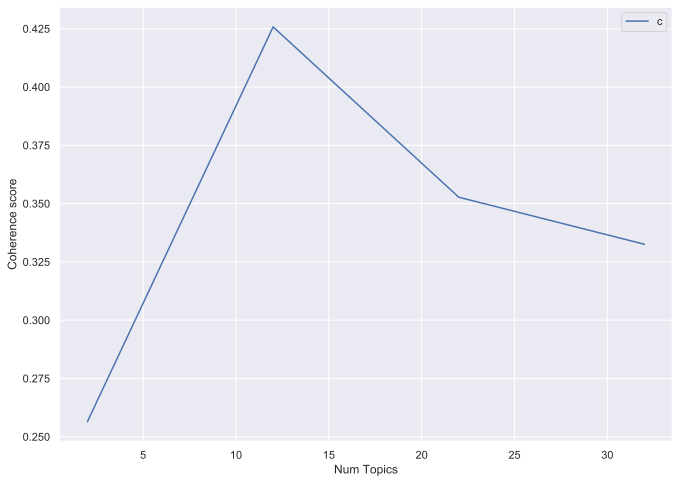

In [55]:
# Show graph
limit=40; start=2; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [48]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2565
Num Topics = 12  has Coherence Value of 0.4258
Num Topics = 22  has Coherence Value of 0.3527
Num Topics = 32  has Coherence Value of 0.3326


At 12, we get best coherence score so, this shows our tiping point

### 6.3)-Optimal Model

In [49]:
# Select the model and print the topics. We choose 6 so, list[1].
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.004*"td" + 0.003*"policy" + 0.003*"neuron" + 0.003*"stimulus" + '
  '0.002*"reward" + 0.002*"word" + 0.002*"memory" + 0.002*"document" + '
  '0.002*"action" + 0.002*"node"'),
 (1,
  '0.024*"cnn" + 0.003*"graph" + 0.003*"image" + 0.002*"speech" + '
  '0.002*"controller" + 0.002*"node" + 0.002*"edge" + 0.002*"tree" + '
  '0.002*"layer" + 0.002*"svm"'),
 (2,
  '0.033*"dropout" + 0.002*"ht" + 0.002*"risk" + 0.002*"image" + '
  '0.002*"source" + 0.002*"agent" + 0.002*"kernel" + 0.002*"object" + '
  '0.001*"neuron" + 0.001*"xi"'),
 (3,
  '0.009*"neuron" + 0.005*"cell" + 0.004*"layer" + 0.004*"unit" + '
  '0.004*"spike" + 0.004*"activity" + 0.003*"stimulus" + 0.003*"recurrent" + '
  '0.003*"trajectory" + 0.003*"memory"'),
 (4,
  '0.031*"policy" + 0.029*"regret" + 0.021*"reward" + 0.018*"bandit" + '
  '0.017*"action" + 0.014*"agent" + 0.013*"arm" + 0.009*"reinforcement" + '
  '0.007*"mdp" + 0.007*"game"'),
 (5,
  '0.008*"lasso" + 0.008*"adversarial" + 0.006*"variational" + 0.004*"gp"

# 7)-Visualization

In [50]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [51]:
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary=lda_model.id2word)

In [52]:
pyLDAvis.save_html(vis, 'topics_optimal.html')